<a href="https://colab.research.google.com/github/shna83/-DFE610-NLP-sentimental-analysis-/blob/DFE61000%5DNLP-FOR-DIGITAL-FINANCE-ENGINEERING/nsmc_bilstm_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#NSMC 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [ ]:
#NSMC 감성분석을 위한 라이브러리
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Twitter
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 58.4MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
     |████████████████████████████████| 460kB 45.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
#pandas로 train set과 test set 데이터 로드
train_data = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test_data = pd.read_csv("nsmc/ratings_test.txt", sep='\t')
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [ ]:
#train data sample
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
#test data sample
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
#train data 중복 존재 여부
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
#train data 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
#train data수
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


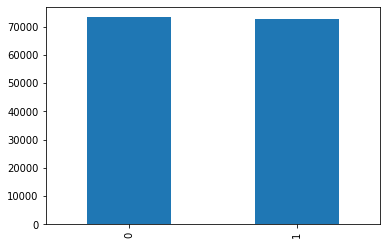

In [ ]:
#train_data label 구성표
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
#train_data label수
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [ ]:
#null 값 존재
print(train_data.isnull().values.any())

True


In [ ]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [ ]:
#null 값 제거
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [ ]:
#train data수
print(len(train_data))

146182


In [ ]:
#한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
#train data 한글 및 공백 제거 후 null 값 존재 여부 확인
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [ ]:
#train_data null sample
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [ ]:
#null 값 제거
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [ ]:
#중복내용 제거 및 정규 표현 후 null 값 제거
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


In [ ]:
#불용어 정의(https://www.ranks.nl/stopwords/korean)
stopwords = ['아','휴','아이구','아이쿠','아이고','어','나','우리','저희','따라','의해','을','를','에',
             '의','가','으로','로','에게','뿐이다','의거하여','근거하여','입각하여','기준으로','예하면',
             '예를 들면','예를 들자면','저','소인','소생','저희','지말고','하지마','하지마라','다른',
             '물론','또한','그리고','비길수 없다','해서는 안된다','뿐만 아니라','만이 아니다','만은 아니다',
             '막론하고','관계없이','그치지 않다','그러나','그런데','하지만','든간에','논하지 않다','따지지 않다',
             '설사','비록','더라도','아니면','만 못하다','하는 편이 낫다','불문하고','향하여','향해서','향하다',
             '쪽으로','틈타','이용하여','타다','오르다','제외하고','이 외에','이 밖에','하여야','비로소','한다면 몰라도',
             '외에도','이곳','여기','부터','기점으로','따라서','할 생각이다','하려고하다','이리하여','그리하여','그렇게 함으로써',
             '하지만','일때','할때','앞에서','중에서','보는데서','으로써','로써','까지','해야한다','일것이다','반드시',
             '할줄알다','할수있다','할수있어','임에 틀림없다','한다면','등','등등','제','겨우','단지','다만','할뿐',
             '딩동','댕그','대해서','대하여','대하면','훨씬','얼마나','얼마만큼','얼마큼','남짓','여','얼마간','약간',
             '다소','좀','조금','다수','몇','얼마','지만','하물며','또한','그러나','그렇지만','하지만','이외에도',
             '대해 말하자면','뿐이다','다음에','반대로','반대로 말하자면','이와 반대로','바꾸어서 말하면',
             '바꾸어서 한다면','만약','그렇지않으면','까악','툭','딱','삐걱거리다','보드득','비걱거리다',
             '꽈당','응당','해야한다','에 가서','각','각각','여러분','각종','각자','제각기','하도록하다',
             '와','과','그러므로','그래서','고로','한 까닭에','하기 때문에','거니와','이지만','대하여','관하여',
             '관한','과연','실로','아니나다를가','생각한대로','진짜로','한적이있다','하곤하였다','하','하하',
             '허허','아하','거바','와','오','왜','어째서','무엇때문에','어찌','하겠는가','무슨','어디','어느곳',
             '더군다나','하물며','더욱이는','어느때','언제','야','이봐','어이','여보시오','흐흐','흥',
             '휴','헉헉','헐떡헐떡','영차','여차','어기여차','끙끙','아야','앗','아야','콸콸','졸졸','좍좍',
             '뚝뚝','주룩주룩','솨','우르르','그래도','또','그리고','바꾸어말하면','바꾸어말하자면','혹은',
             '혹시','답다','및','그에 따르는','때가 되어','즉','지든지','설령','가령','하더라도','할지라도',
             '일지라도','지든지','몇','거의','하마터면','인젠','이젠','된바에야','된이상','만큼','어찌됏든',
             '그위에','게다가','점에서 보아','비추어 보아','고려하면','하게될것이다','일것이다','비교적',
             '좀','보다더','비하면','시키다','하게하다','할만하다','의해서','연이서','이어서','잇따라',
             '뒤따라','뒤이어','결국','의지하여','기대여','통하여','자마자','더욱더','불구하고','얼마든지',
             '마음대로','주저하지 않고','곧','즉시','바로','당장','하자마자','밖에 안된다','하면된다',
             '그래','그렇지','요컨대','다시 말하자면','바꿔 말하면','즉','구체적으로','말하자면','시작하여',
             '시초에','이상','허','헉','허걱','바와같이','해도좋다','해도된다','게다가','더구나','하물며',
             '와르르','팍','퍽','펄렁','동안','이래','하고있었다','이었다','에서','로부터','까지','예하면',
             '했어요','해요','함께','같이','더불어','마저','마저도','양자','모두','습니다','가까스로','하려고하다',
             '즈음하여','다른','다른 방면으로','해봐요','습니까','했어요','말할것도 없고','무릎쓰고','개의치않고',
             '하는것만 못하다','하는것이 낫다','매','매번','들','모','어느것','어느','로써','갖고말하자면','어디',
             '어느쪽','어느것','어느해','어느 년도','라 해도','언젠가','어떤것','어느것','저기','저쪽','저것',
             '그때','그럼','그러면','요만한걸','그래','그때','저것만큼','그저','이르기까지','할 줄 안다','할 힘이 있다',
             '너','너희','당신','어찌','설마','차라리','할지언정','할지라도','할망정','할지언정','구토하다','게우다',
             '토하다','메쓰겁다','옆사람','퉤','쳇','의거하여','근거하여','의해','따라','힘입어','그','다음','버금',
             '두번째로','기타','첫번째로','나머지는','그중에서','견지에서','형식으로 쓰여','입장에서','위해서',
             '단지','의해되다','하도록시키다','뿐만아니라','반대로','전후','전자','앞의것','잠시','잠깐','하면서',
             '그렇지만','다음에','그러한즉','그런즉','남들','아무거나','어찌하든지','같다','비슷하다','예컨대',
             '이럴정도로','어떻게','만약','만일','위에서 서술한바와같이','인 듯하다','하지 않는다면','만약에',
             '무엇','무슨','어느','어떤','아래윗','조차','한데','그럼에도 불구하고','여전히','심지어','까지도',
             '조차도','하지 않도록','않기 위하여','때','시각','무렵','시간','동안','어때','어떠한','하여금','네',
             '예','우선','누구','누가 알겠는가','아무도','줄은모른다','줄은 몰랏다','하는 김에','겸사겸사','하는바',
             '그런 까닭에','한 이유는','그러니','그러니까','때문에','그','너희','그들','너희들','타인','것','것들',
             '너','위하여','공동으로','동시에','하기 위하여','어찌하여','무엇때문에','붕붕','윙윙','나','우리','엉엉',
             '휘익','윙윙','오호','아하','어쨋든','만 못하다','하기보다는','차라리','하는 편이 낫다','흐흐','놀라다',
             '상대적으로 말하자면','마치','아니라면','쉿','그렇지 않으면','그렇지 않다면','안 그러면','아니었다면',
             '하든지','아니면','이라면','좋아','알았어','하는것도','그만이다','어쩔수 없다','하나','일','일반적으로',
             '일단','한켠으로는','오자마자','이렇게되면','이와같다면','전부','한마디','한항목','근거로','하기에',
             '아울러','하지 않도록','않기 위해서','이르기까지','이 되다','로 인하여','까닭으로','이유만으로','이로 인하여',
             '그래서','이 때문에','그러므로','그런 까닭에','알 수 있다','결론을 낼 수 있다','으로 인하여','있다',
             '어떤것','관계가 있다','관련이 있다','연관되다','어떤것들','에 대해','이리하여','그리하여','여부',
             '하기보다는','하느니','하면 할수록','운운','이러이러하다','하구나','하도다','다시말하면','다음으로',
             '에 있다','에 달려 있다','우리','우리들','오히려','하기는한데','어떻게','어떻해','어찌됏어','어때',
             '어째서','본대로','자','이','이쪽','여기','이것','이번','이렇게말하자면','이런','이러한','이와 같은',
             '요만큼','요만한 것','얼마 안 되는 것','이만큼','이 정도의','이렇게 많은 것','이와 같다','이때',
             '이렇구나','것과 같이','끼익','삐걱','따위','와 같은 사람들','부류의 사람들','왜냐하면','중의하나',
             '오직','오로지','에 한하다','하기만 하면','도착하다','까지 미치다','도달하다','정도에 이르다','할 지경이다',
             '결과에 이르다','관해서는','여러분','하고 있다','한 후','혼자','자기','자기집','자신','우에 종합한것과같이',
             '총적으로 보면','총적으로 말하면','총적으로','대로 하다','으로서','참','그만이다','할 따름이다','쿵',
             '탕탕','쾅쾅','둥둥','봐','봐라','아이야','아니','와아','응','아이','참나','년','월','일','령','영','일',
             '이','삼','사','오','육','륙','칠','팔','구','이천육','이천칠','이천팔','이천구','하나','둘','셋','넷','다섯',
             '여섯','일곱','여덟','아홉','령','영']

In [ ]:
#train data okt 형태소 분석기 사용, 토큰화 및 불용어 제거
okt = Okt()
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

In [ ]:
#토큰화 sample 
print(X_train[:5])

[['더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍다', '않다'], ['무재', '밓었', '다그', '래서', '보다', '추천', '한', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', '평점', '조정'], ['사이', '몬페', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '늙다', '보이다', '하다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']]


In [ ]:
#test data okt 형태소 분석기 사용, 토큰화 및 불용어 제거
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [ ]:
#train data 정수화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '하다': 3, '도': 4, '는': 5, '은': 6, '없다': 7, '이다': 8, '좋다': 9, '너무': 10, '다': 11, '정말': 12, '한': 13, '되다': 14, '재밌다': 15, '적': 16, '만': 17, '진짜': 18, '아니다': 19, '않다': 20, '점': 21, '만들다': 22, '나오다': 23, '연기': 24, '평점': 25, '내': 26, '최고': 27, '안': 28, '인': 29, '스토리': 30, '생각': 31, '못': 32, '드라마': 33, '게': 34, '감동': 35, '사람': 36, '보고': 37, '이렇다': 38, '말': 39, '고': 40, '아깝다': 41, '더': 42, '배우': 43, 'ㅋㅋ': 44, '감독': 45, '거': 46, '그냥': 47, '재미있다': 48, '요': 49, '재미': 50, '내용': 51, '뭐': 52, '중': 53, '주다': 54, '자다': 55, '하고': 56, '지루하다': 57, '재미없다': 58, '쓰레기': 59, '수': 60, '모르다': 61, '가다': 62, '들다': 63, '그렇다': 64, '싶다': 65, '지': 66, '작품': 67, '사랑': 68, '알다': 69, '다시': 70, '마지막': 71, '볼': 72, '잘': 73, '이건': 74, '정도': 75, '완전': 76, '오다': 77, 'ㅋ': 78, 'ㅠㅠ': 79, '많다': 80, '처음': 81, 'ㅋㅋㅋ': 82, '장면': 83, '액션': 84, '주인공': 85, '이렇게': 86, '안되다': 87, '걸': 88, '차다': 89, '나다': 90, '개': 91, '최악': 92, '돈': 93, '이야기': 94, '지금': 95, '넘다': 96, '느낌': 97, '임': 98, '연출': 99, 'ㅡㅡ': 100, '라': 101, '인데

In [ ]:
threshold = 3 #등장 횟수
total_cnt = len(tokenizer.word_index) #단어 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 수 :',total_cnt)
print('등장 빈도가 %s번 이하인 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 2번 이하인 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 2번 이하인 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 수 : 43510
등장 빈도가 2번 이하인 단어의 수: 24308
단어 집합에서 2번 이하인 단어의 비율: 55.86761663985291
전체 등장 빈도에서 2번 이하인 단어 등장 빈도 비율: 1.9465184373939897


In [ ]:
#전체 단어 개수 중 2번 이하인 단어 개수 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19204


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#정수 인코딩 sample
print(X_train[:5])

[[411, 19, 230, 593], [852, 414, 38, 543, 2, 190, 1349, 25, 607, 21], [2314, 1, 2189, 5505, 3, 197, 14, 12], [6322, 95, 7939, 194, 51, 6, 8, 26, 3453], [938, 1, 8959, 25, 754, 2, 2445, 1021, 213, 4, 14041, 1, 990, 225, 213]]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
#2번 이하 단어 제거 후 null값 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
#null 값 sample 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145294
145294


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 71
리뷰의 평균 길이 : 10.57042272908723


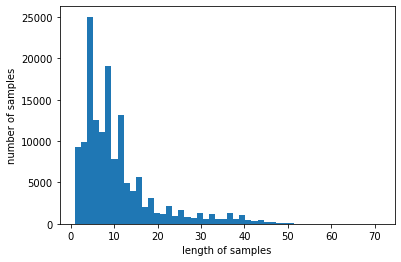

In [ ]:
#sample length 일치 padding
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.62125070546615


In [ ]:
#sample length = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import tensorflow as tf

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, Model
import os

In [ ]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [ ]:
lstm = Bidirectional(LSTM(128, dropout=0.5, return_sequences = True))(embedded_sequences)

In [ ]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [ ]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 30, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [ ]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [ ]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [ ]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#data 손실이 4회 증가하면 조기종료
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/10
1817/1817 [==============================] - 606s 321ms/step - loss: 0.4703 - accuracy: 0.7770 - val_loss: 0.3483 - val_accuracy: 0.8460
Epoch 2/10
1817/1817 [==============================] - 574s 316ms/step - loss: 0.3244 - accuracy: 0.8650 - val_loss: 0.3554 - val_accuracy: 0.8494
Epoch 3/10
1817/1817 [==============================] - 588s 324ms/step - loss: 0.2832 - accuracy: 0.8836 - val_loss: 0.3539 - val_accuracy: 0.8502
Epoch 4/10
1817/1817 [==============================] - 579s 319ms/step - loss: 0.2529 - accuracy: 0.8970 - val_loss: 0.3830 - val_accuracy: 0.8480
Epoch 5/10
1817/1817 [==============================] - 582s 320ms/step - loss: 0.2253 - accuracy: 0.9092 - val_loss: 0.4005 - val_accuracy: 0.8489
Epoch 00005: early stopping


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 54s 35ms/step - loss: 0.4070 - accuracy: 0.8421

 테스트 정확도: 0.8421


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    result = 1
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    result = 0
  return result

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/ko_data.csv', encoding = 'cp949')

In [ ]:
cols = ['Id','result']
listdict = []

In [ ]:
for index, row in data.iterrows():
    result = sentiment_predict(row["Sentence"])
    rowId = row["Id"]
    listdict.append({'Id':str(rowId), 'result':str(result)})
    output = pd.DataFrame(listdict,columns=cols)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
77.54% 확률로 긍정 리뷰입니다.

96.78% 확률로 긍정 리뷰입니다.

77.87% 확률로 부정 리뷰입니다.

82.91% 확률로 부정 리뷰입니다.

97.94% 확률로 긍정 리뷰입니다.

62.28% 확률로 부정 리뷰입니다.

95.21% 확률로 긍정 리뷰입니다.

64.69% 확률로 긍정 리뷰입니다.

57.57% 확률로 부정 리뷰입니다.

77.50% 확률로 부정 리뷰입니다.

98.34% 확률로 부정 리뷰입니다.

83.43% 확률로 부정 리뷰입니다.

95.63% 확률로 긍정 리뷰입니다.

96.27% 확률로 부정 리뷰입니다.

52.73% 확률로 부정 리뷰입니다.

98.75% 확률로 긍정 리뷰입니다.

93.18% 확률로 긍정 리뷰입니다.

99.57% 확률로 부정 리뷰입니다.

76.29% 확률로 부정 리뷰입니다.

72.80% 확률로 부정 리뷰입니다.

90.27% 확률로 부정 리뷰입니다.

57.37% 확률로 긍정 리뷰입니다.

73.84% 확률로 부정 리뷰입니다.

56.22% 확률로 부정 리뷰입니다.

99.37% 확률로 부정 리뷰입니다.

98.54% 확률로 부정 리뷰입니다.

94.94% 확률로 긍정 리뷰입니다.

99.13% 확률로 부정 리뷰입니다.

99.62% 확률로 긍정 리뷰입니다.

78.40% 확률로 긍정 리뷰입니다.

97.45% 확률로 긍정 리뷰입니다.

99.87% 확률로 부정 리뷰입니다.

99.66% 확률로 긍정 리뷰입니다.

71.09% 확률로 부정 리뷰입니다.

100.00% 확률로 긍정 리뷰입니다.

77.48% 확률로 긍정 리뷰입니다.

82.88% 확률로 부정 리뷰입니다.

99.95% 확률로 긍정 리뷰입니다.

99.97% 확률로 부정 리뷰입니다.

81.39% 확률로 긍정 리뷰입니다.

59.53% 확률로 부정 리뷰입니다.

82.12% 확률로 긍정 리뷰입니다.

84.65% 확률로 부정 리뷰입니다.

81.65% 확률로 긍정 리뷰입

In [ ]:
output

,Id,result
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
11182,11182,1
11183,11183,0
11184,11184,1
11185,11185,1


In [ ]:
output.to_csv('/content/gdrive/My Drive/bilstm_attention_64batch_test.csv')